In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import gym
import os
from datetime import datetime
import random
import string
import multiprocessing as mp
import itertools

In [2]:
import matplotlib.pyplot as plt
import timeit
%load_ext memory_profiler


In [3]:
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

In [4]:
REWARD = 100

In [5]:
seed = 9295
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

env = gym.make('CartPole-v0')
XTRA_FEAT   = 0 #masscart, masspole, length
N_ACTIONS   = env.action_space.n
N_STATES    = env.observation_space.shape[0]  +  XTRA_FEAT 
ENV_A_SHAPE = 0 if isinstance(env.action_space.sample(), int) else env.action_space.sample().shape     # to confirm the shape

In [6]:
RNDM_STRING = ''.join(random.choices(string.ascii_uppercase + string.digits, k=8)) + datetime.now().strftime("_%H_%M_%S")
print("ID: ",RNDM_STRING)
MODEL_FILENAME = './models/'+ RNDM_STRING + "_NN" + ".pt"
print("NN-MODEL FILENAME: ", MODEL_FILENAME)

ID:  VBKG0BIX_14_46_11
NN-MODEL FILENAME:  ./models/VBKG0BIX_14_46_11_NN.pt


In [7]:
def ndim_grid(start,stop, granularity):
    # Set number of dimensions
    ndims = len(start)

    # List of ranges across all dimensions
    L = [np.linspace(start[i],stop[i],granularity[i]) for i in range(ndims)]

    # Finally use meshgrid to form all combinations corresponding to all 
    # dimensions and stack them as M x ndims array
    return np.hstack((np.meshgrid(*L))).swapaxes(0,1).reshape(ndims,-1).T

In [8]:
def discretize(value, borders):
    c_pos_val, c_vel_val, p_ang_val, p_vel_val   = value
    c_pos_s  , c_vel_s  ,p_ang_s   , p_vel_s     = borders
    
    indx = np.empty_like(value).astype(np.intp)
    
    for i in range(value.shape[0]):
        if value[i] > borders[i].max():
            indx[i] = borders[i].argmax().astype(np.intp)
        else:
            indx[i] = np.where(borders[i] >= value[i])[0][0].astype(np.intp)
    return indx



In [9]:
T_LR           = 1e-2
T_GAMMA        = 0.99
T_EPSILON      = 0.98

NO_OF_NODES    = 10
NO_OF_EPISODES = 100
TIMESTEP_LIMIT = 200

print("Number of NODES: ", NO_OF_NODES)
print("Number of EPISODES per NODE", NO_OF_EPISODES)

Number of NODES:  10
Number of EPISODES per NODE 100


In [10]:
# Hyper Parameters
HIDDEN_LAYER        = 50
BATCH_SIZE          = 32
NN_LR               = 1e-3  # learning rate
NN_GAMMA            = 0.9   # reward discount
TARGET_REPLACE_ITER = 500   # target update frequency
MIN_MEMORY_CAP      = 200000

In [11]:
MAX_NO_OF_ITERATIONS = 50
MAX_NN_ITERATIONS    = 50000
print("Number of ITERATIONS: ",MAX_NO_OF_ITERATIONS)

Number of ITERATIONS:  50


In [12]:
# class Net(nn.Module):
#     def __init__(self, ):
#         super(Net, self).__init__()
#         self.fc1 = nn.Linear(N_STATES, 50)
#         nn.init.kaiming_uniform_(self.fc1.weight)   # initialization
#         self.out = nn.Linear(50, N_ACTIONS)
#         nn.init.xavier_uniform_(self.out.weight)   # initialization

#     def forward(self, x):
#         x = self.fc1(x)
#         x = F.relu(x)
#         actions_value = self.out(x)
#         return actions_value

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(N_STATES, HIDDEN_LAYER)
        nn.init.kaiming_uniform_(self.fc1.weight)

        self.adv = nn.Linear(HIDDEN_LAYER, N_ACTIONS)
        nn.init.xavier_uniform_(self.adv.weight) 
    
        self.val = nn.Linear(HIDDEN_LAYER, 1)
        nn.init.xavier_uniform_(self.val.weight)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)

        adv = self.adv(x)
        val = self.val(x)
        
        return val + adv - adv.mean()
    
class D3QN(object):
    def __init__(self):
        self.eval_net, self.target_net = Net(), Net()

        self.learn_step_counter  = 0 # for target updating
        
        self.memory_counter      = 0
        self.memory              = np.zeros((int(MIN_MEMORY_CAP), N_STATES * 2 + 2)) # initialize memory
        
#         self.good_memory_counter = 0 # for storing non-terminal memories
#         self.good_memory         = np.zeros((MIN_MEMORY_CAP ,N_STATES*2+2))#np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2)) # initialize memory
        
#         self.bad_memory_counter  = 0 # for storing terminal memories
#         self.bad_memory          = np.zeros((MIN_MEMORY_CAP , N_STATES*2+2))#np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2)) # initialize memory
        self.running_loss        = 0
        self.optimizer           = torch.optim.Adam(self.eval_net.parameters(), lr=NN_LR)
        self.loss_func           = nn.MSELoss()

    def choose_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        if np.random.uniform() < EPSILON:   # greedy
            actions_value = self.eval_net.forward(x)
            action = torch.max(actions_value, 1)[1].data.numpy()
            action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        else:   # random
            action = np.random.randint(0, N_ACTIONS)
            action = action if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)
        return action
    
    def choose_greedy_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        actions_value = self.eval_net.forward(x)
        action = torch.max(actions_value, 1)[1].data.numpy()
        action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        return action
    
    def get_greedy_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        actions = self.eval_net.forward(x).view(-1,N_ACTIONS).max(1)[1].data.numpy().astype(np.intp)
#         actions_value 
#         action = torch.max(actions_value, 1)[1].data.numpy()
#         action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        return actions
    
    def get_qvals(self,x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        actions_value = self.eval_net.forward(x)
        actions_value = actions_value.data.numpy().astype(np.float16)
        return actions_value

    def learn(self):
        # target parameter update
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            self.target_net.load_state_dict(self.eval_net.state_dict())
        self.learn_step_counter += 1
        
        sample_index_limit = min(MIN_MEMORY_CAP, self.memory_counter)
        sample_index = np.random.choice(int(sample_index_limit),int(BATCH_SIZE))
        b_memory = self.memory[sample_index,:]
#         # sample batch transitions
#         good_sample_index_limit = min(MIN_MEMORY_CAP, self.good_memory_counter)
#         bad_sample_index_limit = min(MIN_MEMORY_CAP, self.bad_memory_counter)

#         good_sample_index = np.random.choice(int(good_sample_index_limit), int(BATCH_SIZE-int(BATCH_SIZE*TERMINAL_BIAS)))
#         bad_sample_index  = np.random.choice(int(bad_sample_index_limit),  int(BATCH_SIZE*TERMINAL_BIAS))

#         b_good_memory = self.good_memory[good_sample_index, :]
#         b_bad_memory  = self.bad_memory[bad_sample_index, :]
#         b_memory      = np.vstack((b_good_memory,b_bad_memory))
        
        b_s  = torch.FloatTensor(b_memory[:, :N_STATES])
        b_a  = torch.LongTensor( b_memory[:, N_STATES:N_STATES+1].astype(int))
        b_r  = torch.FloatTensor(b_memory[:, N_STATES+1:N_STATES+2])
        b_s_ = torch.FloatTensor(b_memory[:, -N_STATES:])

        # q_eval w.r.t the action in experience
        q_eval   = self.eval_net(b_s).gather(1, b_a)  # shape (batch, 1)
        a_eval   = self.eval_net(b_s).max(1)[1].view(BATCH_SIZE, 1) #best action according to eval_net
        q_next   = self.target_net(b_s_).detach()     # detach from graph, don't backpropagate
        q_target = b_r + NN_GAMMA * q_next.gather(1, a_eval)   # shape (batch, 1)
        loss     = self.loss_func(q_eval, q_target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        self.running_loss += loss.mean().item()
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            print('LOSS : %.3f' %(self.running_loss / TARGET_REPLACE_ITER), end="\t")
            self.running_loss = 0.0

In [13]:
def clamp(MIN_VAL, VAL, MAX_VAL):
    return max(MIN_VAL, min(VAL, MAX_VAL))

In [14]:
# ABSOLUTE LIMITS ON STATE VALUES
C_POS_ABS_MAX =  2.6
C_POS_ABS_MIN = -2.6

C_VEL_ABS_MAX =  5
C_VEL_ABS_MIN = -5

P_ANG_ABS_MAX =  0.25
P_ANG_ABS_MIN = -0.25

P_VEL_ABS_MAX =  6
P_VEL_ABS_MIN = -6

In [15]:
# SET GRANULARITY
HI_GRAIN = 40
print("HI_GRAIN = ", HI_GRAIN)

HI_GRAIN =  40


In [16]:
def mp_node_run(node_id, boundary, iteration, p_table):

    # SET SEED
    ###############################################
    my_seed = seed + node_id + iteration
    random.seed(my_seed)
    torch.manual_seed(my_seed)
    np.random.seed(my_seed)
    os.environ['PYTHONHASHSEED'] = str(my_seed)
    my_env = env
    my_env.seed(my_seed)
    ###############################################

    # SET STATE VALUE BORDERS
    ###############################################
    [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX,
     C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN]  = boundary
    
    
    # CREATE STATE TABLE BORDERS
    ###############################################
    c_pos_s  = np.linspace(C_POS_MIN,  C_POS_MAX,  HI_GRAIN)
    c_vel_s  = np.linspace(C_VEL_MIN,  C_VEL_MAX,  HI_GRAIN)
    p_ang_s  = np.linspace(P_ANG_MIN,  P_ANG_MAX,  HI_GRAIN)
    p_vel_s  = np.linspace(P_VEL_MIN,  P_VEL_MAX,  HI_GRAIN)

    my_borders = [c_pos_s, c_vel_s, p_ang_s, p_vel_s]
    ###############################################
    
    my_Q_TABLE = p_table
    time_rec                = np.zeros(NO_OF_EPISODES)
    level_up_flag           = False
    PERFECT_RUN_COUNTER     = 10
    PERFECT_RUNS_HIGH_SCORE = 10
    level_up_metric         = 195

    exp_rec      = np.empty(N_STATES * 2 + 2)
    
#     if iteration < 3:
    my_EPSILON   = np.clip(((3%5 + 1)*0.1 + (iteration)*0.2) ,0.4,0.98)+ np.random.uniform(-0.01,0.01)
#     print(node_id, my_EPSILON)
#     else:
#         my_EPSILON   = T_EPSILON + np.random.uniform(-0.01,0.01)
    
    while True:
        i_episode = 0
        
        while i_episode < NO_OF_EPISODES:
            ep_exp_rec = np.empty(N_STATES * 2 + 2)
            time_steps = 0
            
            s = my_env.reset()
            
            while True:
                time_steps += 1
                
                #get state
                this_state = tuple(discretize(s, my_borders))
                
                # choose action
                if np.random.uniform() > my_EPSILON:   # greedy
                    a = (node_id%N_ACTIONS)#np.random.randint(0, N_ACTIONS)
                else:
                    a = my_Q_TABLE[this_state]

                 # take action
                s_, r, done, info = my_env.step(a)

                if done:
                    r = -REWARD
                    if time_steps >= TIMESTEP_LIMIT:
                        r = REWARD
                
                #store experience
                experience = np.hstack((s,a,r,s_))
                exp_rec = np.vstack((exp_rec, experience))

                #discretize next_state
                next_state = tuple(discretize(s_, my_borders))
                
                if done or time_steps >= TIMESTEP_LIMIT:
                    time_rec[i_episode] = time_steps
                    break
                s = s_

            i_episode += 1
        if i_episode >= NO_OF_EPISODES:
            i_episode = 0
            break

    exp_rec = np.delete(exp_rec, 0, 0)
#         message = "NODE#"+str(node_id) +" MAIN Q:"+ str(new_Q_TABLE.mean()) +"\t" + "NODE Q:" + str(my_Q_TABLE.mean())
#         print(message)

#     GET NEW STATE BOUNDARIES: +/- 25% of experienced state
    new_max = np.array([exp_rec[:,i].max() for i in range(N_STATES)])
    new_min = np.array([exp_rec[:,i].min() for i in range(N_STATES)])
    

    if iteration >= 4: 

        old_max = np.array(boundary[:4])
        old_min = np.array(boundary[4:])

        newboundary_max = old_max
        newboundary_min = old_min

        damper = 0.6
        for i in range(N_STATES):
            newboundary_max[i] = new_max[i] if new_max[i] >= old_max[i] else (old_max[i]*damper+new_max[i]*(1-damper))
            newboundary_min[i] = new_min[i] if new_min[i] <= old_min[i] else (old_min[i]*damper+new_min[i]*(1-damper))
            
            MARGIN = 2*(newboundary_max - newboundary_min)/HI_GRAIN

        newboundary = np.concatenate((newboundary_max + MARGIN,
                                      newboundary_min - MARGIN))
    else:
        MARGIN = 2*(new_max - new_min)/HI_GRAIN
        newboundary = np.concatenate((new_max + MARGIN,
                                      new_min + MARGIN))

        
#   # CLAMP STATE VALUE BORDERS
    ##############################################
    newboundary[0] = clamp(C_POS_ABS_MIN, newboundary[0], C_POS_ABS_MAX)
    newboundary[4] = clamp(C_POS_ABS_MIN, newboundary[4], C_POS_ABS_MAX) 

    newboundary[1] = clamp(C_VEL_ABS_MIN, newboundary[1], C_VEL_ABS_MAX)
    newboundary[5] = clamp(C_VEL_ABS_MIN, newboundary[5], C_VEL_ABS_MAX) 

    newboundary[2] = clamp(P_ANG_ABS_MIN, newboundary[2], P_ANG_ABS_MAX)
    newboundary[6] = clamp(P_ANG_ABS_MIN, newboundary[6], P_ANG_ABS_MAX) 

    newboundary[3] = clamp(P_VEL_ABS_MIN, newboundary[3], P_VEL_ABS_MAX)
    newboundary[7] = clamp(P_VEL_ABS_MIN, newboundary[7], P_VEL_ABS_MAX)
    
#     newboundary = [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX,
#                     C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN]
    
    return exp_rec, time_rec, newboundary

In [17]:
total_serial_timesteps   = 0
total_parallel_timesteps = 0

In [18]:
iteration = 0
# my_dqn = D3QN()
dqn = D3QN()

# INITIALIZE BOUNDARY TO MAXIMUM VALUES
init_node_boundary = [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX,
                      C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN]



# CREATE STATE COMBINATIONS
# ###############################################

init_state_combinations = ndim_grid([C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN],
                                    [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX],
                                    [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN])



# # GET Q-VALUES 
start = timeit.default_timer()
%memit init_q_table = dqn.get_greedy_action(init_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN).astype(np.intp)
stop = timeit.default_timer()
print("Quantization TIME: ", np.round((stop-start)/60,2), "minutes")
    
# SAVE QFILE
# node_QFILE = './Q_NPY/' + RNDM_STRING + 'QFILE' + ".npy"
# np.save(node_QFILE, init_q_table)

peak memory: 1256.62 MiB, increment: 1035.91 MiB
Quantization TIME:  0.01 minutes


In [19]:
# ENVIRONMENT FOR CHECKING NN MODEL
v_env = gym.make('CartPole-v0')
v_env.seed(seed*2)

# CREATE A POOL OF PROCESSES
pool = mp.Pool(NO_OF_NODES)

# SET INITIAL NODE BOUDNARIES FOR ALL NODES
node_boundaries = [init_node_boundary] * NO_OF_NODES
node_q_table = init_q_table
q_table_list = [node_q_table]* NO_OF_NODES




ITERATION # 0
TOTAL EXPERIENCE GENERATED:   14548
SMALLEST TIMESTEP: 8
LARGEST  TIMESTEP: 71
TOTAL SERIAL TIMESTEPS:   14548
TOTAL PARALLEL TIMESTEPS: 71


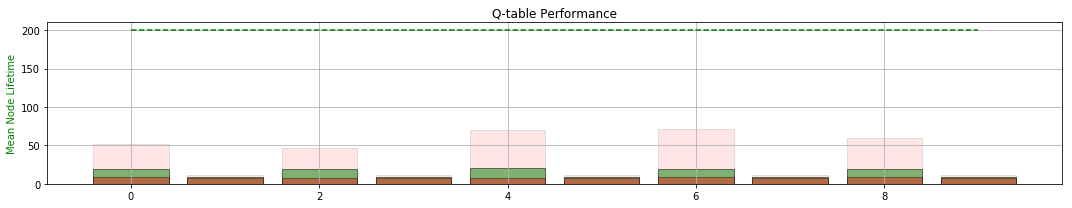

MEMORY COUNTER:  14548
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 597.093	LOSS : 542.516	LOSS : 526.025	LOSS : 527.202	LOSS : 495.930	LOSS : 483.411	LOSS : 487.120	LOSS : 478.204	LOSS : 482.698	LOSS : 485.022	LOSS : 468.334	LOSS : 467.721	LOSS : 475.096	LOSS : 451.394	LOSS : 428.369	LOSS : 436.966	LOSS : 433.642	LOSS : 403.863	LOSS : 416.081	LOSS : 410.563	
Validating... MEAN TIME:  117.035
LOSS : 399.733	LOSS : 390.235	LOSS : 422.137	LOSS : 393.125	LOSS : 405.615	LOSS : 394.714	LOSS : 385.903	LOSS : 384.425	LOSS : 380.591	LOSS : 377.881	LOSS : 371.789	LOSS : 381.548	LOSS : 371.061	LOSS : 376.900	LOSS : 367.076	LOSS : 374.503	LOSS : 369.707	LOSS : 381.605	LOSS : 359.125	LOSS : 370.099	
Validating... MEAN TIME:  120.505
LOSS : 364.838	LOSS : 354.642	LOSS : 373.788	LOSS : 357.332	LOSS : 363.423	LOSS : 368.991	LOSS : 348.900	LOSS : 350.672	LOSS : 351.575	LOSS : 352.656	LOSS : 346.923	LOSS : 355.169	LOSS : 339.848	LOSS : 353.283	LOSS : 343.473	LOSS : 344.034	LOSS : 3

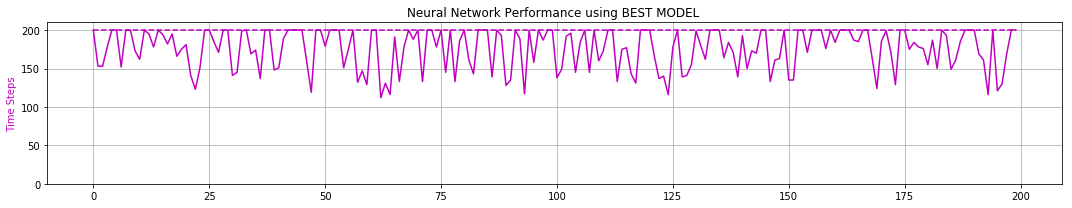

0 -max- 0.2360316671698124
0 -min- -0.3989995847748397

peak memory: 1343.50 MiB, increment: 1064.49 MiB
Quantization TIME:  0.01 minutes
1 -max- 0.23706235781803828
1 -min- -0.03527014308158469

peak memory: 1369.35 MiB, increment: 1051.02 MiB
Quantization TIME:  0.01 minutes
2 -max- 0.23530554253829475
2 -min- -0.3281328653300394

peak memory: 1388.57 MiB, increment: 1050.75 MiB
Quantization TIME:  0.01 minutes
3 -max- 0.23264720810693015
3 -min- -0.03454967293016321

peak memory: 1392.47 MiB, increment: 1034.97 MiB
Quantization TIME:  0.01 minutes
4 -max- 0.2528491350036507
4 -min- -0.5421464248359749

peak memory: 1411.93 MiB, increment: 1034.75 MiB
Quantization TIME:  0.01 minutes
5 -max- 0.23711374132956628
5 -min- -0.03507441801818034

peak memory: 1431.53 MiB, increment: 1034.93 MiB
Quantization TIME:  0.01 minutes
6 -max- 0.266248597655012
6 -min- -0.218047594083023

peak memory: 1480.97 MiB, increment: 1064.69 MiB
Quantization TIME:  0.01 minutes
7 -max- 0.23223827996595225
7

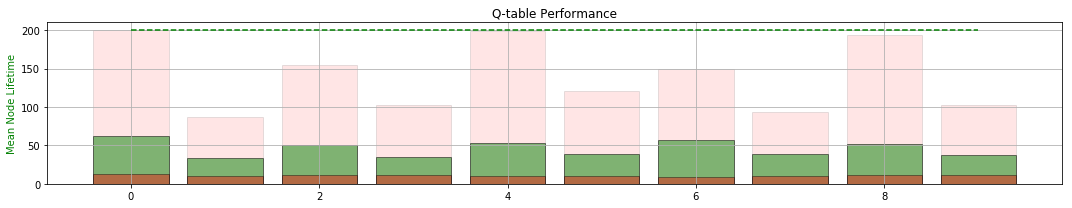

MEMORY COUNTER:  60385
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 410.184	LOSS : 385.617	LOSS : 388.055	LOSS : 374.106	LOSS : 341.373	LOSS : 340.911	LOSS : 335.304	LOSS : 334.068	LOSS : 332.301	LOSS : 302.184	LOSS : 308.605	LOSS : 305.028	LOSS : 292.067	LOSS : 311.517	LOSS : 303.637	LOSS : 270.817	LOSS : 305.616	LOSS : 298.642	LOSS : 306.689	LOSS : 294.372	
Validating... MEAN TIME:  190.68
LOSS : 300.999	LOSS : 300.134	LOSS : 288.594	LOSS : 306.002	LOSS : 304.773	LOSS : 284.540	LOSS : 296.469	LOSS : 299.959	LOSS : 298.781	LOSS : 300.851	LOSS : 302.374	LOSS : 315.521	LOSS : 306.469	LOSS : 312.930	LOSS : 320.887	LOSS : 311.934	LOSS : 321.865	LOSS : 321.537	LOSS : 324.754	LOSS : 319.364	
Validating... MEAN TIME:  200.0
LOSS : 322.775	LOSS : 329.174	LOSS : 326.187	LOSS : 328.154	LOSS : 327.264	LOSS : 318.110	LOSS : 338.749	LOSS : 345.934	LOSS : 336.908	LOSS : 341.024	LOSS : 334.939	LOSS : 357.801	LOSS : 362.493	LOSS : 361.525	LOSS : 365.283	LOSS : 381.232	LOSS : 344.

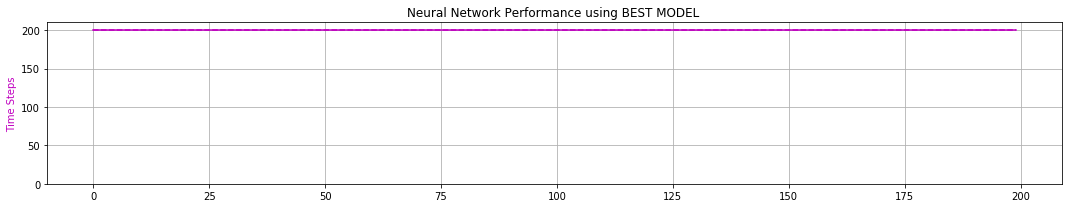

0 -max- 1.3742383031558005
0 -min- -0.8414710998828027

peak memory: 1581.40 MiB, increment: 1064.23 MiB
Quantization TIME:  0.01 minutes
1 -max- 0.27107169503235923
1 -min- -0.6956335141275215

peak memory: 1601.26 MiB, increment: 1035.25 MiB
Quantization TIME:  0.01 minutes
2 -max- 1.4235139545303295
2 -min- -0.24680370263766604

peak memory: 1601.47 MiB, increment: 1016.03 MiB
Quantization TIME:  0.01 minutes
3 -max- 0.2563780736546577
3 -min- -0.6975054061108715

peak memory: 1572.46 MiB, increment: 967.59 MiB
Quantization TIME:  0.2 minutes
4 -max- 1.5664037852974864
4 -min- -0.3850938637843399

peak memory: 1617.80 MiB, increment: 1056.23 MiB
Quantization TIME:  0.03 minutes
5 -max- 0.2875789782490854
5 -min- -0.5680427573007676

peak memory: 1637.22 MiB, increment: 1054.59 MiB
Quantization TIME:  0.03 minutes
6 -max- 1.247693487280513
6 -min- -0.44672728981164883

peak memory: 1642.27 MiB, increment: 1040.22 MiB
Quantization TIME:  0.02 minutes
7 -max- 0.2945111970637743
7 -min-

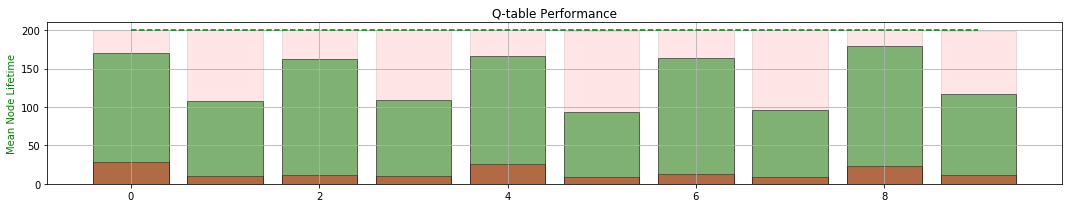

MEMORY COUNTER:  197100
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 370.333	LOSS : 348.008	LOSS : 324.160	LOSS : 338.255	LOSS : 309.315	LOSS : 318.811	LOSS : 282.824	LOSS : 291.547	LOSS : 282.476	LOSS : 286.101	LOSS : 302.050	LOSS : 279.128	LOSS : 258.133	LOSS : 288.811	LOSS : 260.346	LOSS : 257.525	LOSS : 263.846	LOSS : 257.271	LOSS : 256.605	LOSS : 246.181	
Validating... MEAN TIME:  200.0
LOSS : 232.746	LOSS : 251.521	LOSS : 256.596	LOSS : 237.474	LOSS : 237.171	LOSS : 234.483	LOSS : 220.454	LOSS : 220.872	LOSS : 234.749	LOSS : 237.117	LOSS : 237.669	LOSS : 242.680	LOSS : 244.053	LOSS : 237.327	LOSS : 235.132	LOSS : 268.920	LOSS : 223.059	LOSS : 232.943	LOSS : 223.334	LOSS : 218.689	
Validating... MEAN TIME:  200.0
LOSS : 235.403	LOSS : 239.170	LOSS : 232.181	LOSS : 249.242	LOSS : 250.975	LOSS : 238.159	LOSS : 239.134	LOSS : 242.904	LOSS : 243.870	LOSS : 237.754	LOSS : 217.854	LOSS : 234.790	LOSS : 230.423	LOSS : 226.536	LOSS : 229.639	LOSS : 244.924	LOSS : 248.

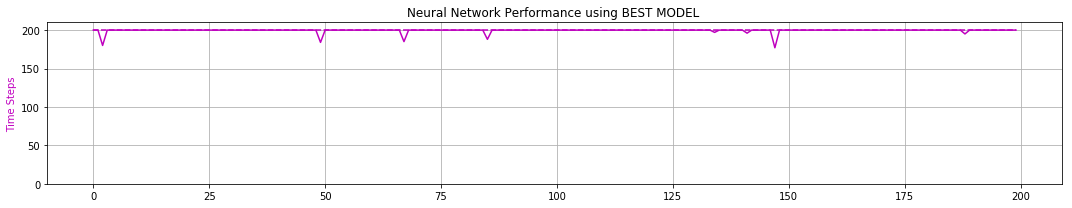

0 -max- 0.6184729936755115
0 -min- -2.0577905945111414

peak memory: 1679.99 MiB, increment: 976.96 MiB
Quantization TIME:  0.01 minutes
1 -max- 0.31533768171381393
1 -min- -2.2705015545405485

peak memory: 1679.99 MiB, increment: 976.57 MiB
Quantization TIME:  0.01 minutes
2 -max- 1.6791230805959587
2 -min- -2.1644680800334304

peak memory: 1679.99 MiB, increment: 976.57 MiB
Quantization TIME:  0.01 minutes
3 -max- 0.3426242212494969
3 -min- -2.2686339519917795

peak memory: 1679.99 MiB, increment: 976.57 MiB
Quantization TIME:  0.01 minutes
4 -max- 0.8911388714005892
4 -min- -1.9472161390539726

peak memory: 1679.99 MiB, increment: 976.57 MiB
Quantization TIME:  0.01 minutes
5 -max- 0.31742114518580866
5 -min- -2.2688435135284997

peak memory: 1679.99 MiB, increment: 976.57 MiB
Quantization TIME:  0.01 minutes
6 -max- 1.0013014471522372
6 -min- -2.219500472717097

peak memory: 1687.82 MiB, increment: 1004.27 MiB
Quantization TIME:  0.01 minutes
7 -max- 0.3324594495339246
7 -min- -2.2

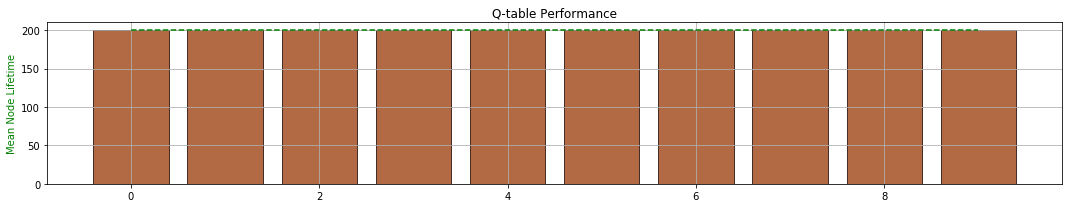

In [20]:
while iteration < MAX_NO_OF_ITERATIONS:

    print("\n")
    print("ITERATION #", iteration)
    tic = datetime.now()
    
    # MAP GYM ENVIRONMENT TO EACH PROCESS IN THE POOL
    ##################################################################
    iter_list = [iteration] * NO_OF_NODES
    arg_list = [arg for arg in zip(range(NO_OF_NODES), node_boundaries, iter_list, q_table_list)]
    result   = pool.starmap(mp_node_run, arg_list)
    ##################################################################
    
    # GATHER RESULTS
    ##################################################################
    node_boundaries = np.array([item[2] for item in result])
    node_time_rec   = np.array([item[1] for item in result])
    node_exp        = np.array([item[0] for item in result])
    
    all_exp         = np.array([item for each_node_exp in node_exp 
                                    for episode_exp in each_node_exp 
                                    for item in episode_exp]).reshape(-1,N_STATES*2+2)
    total_parallel_timesteps += node_time_rec.max()
    total_serial_timesteps   += node_time_rec.sum()
    EXP_GEN = node_time_rec.sum().astype(int)
    
    print("TOTAL EXPERIENCE GENERATED:   {:d}".format(EXP_GEN.astype(int)))

    print("SMALLEST TIMESTEP: {:d}".format(node_time_rec.min().astype(int)))
    print("LARGEST  TIMESTEP: {:d}".format(node_time_rec.max().astype(int)))

    print("TOTAL SERIAL TIMESTEPS:   {:d}".format(total_serial_timesteps.astype(int)))
    print("TOTAL PARALLEL TIMESTEPS: {:d}".format(total_parallel_timesteps.astype(int)))
    ##################################################################

    # PLOT EXPERIENCES
    ##################################################################
    node_avg_time = node_time_rec.mean(axis=1)
    node_std_time = node_time_rec.std(axis=1)
    node_max_time = node_time_rec.max(axis=1)
    node_min_time = node_time_rec.min(axis=1)

    fig = plt.figure(figsize = (15,3))
    ax2 = fig.add_subplot(1, 1, 1)
    ax2.set_title("Q-table Performance")
    ax2.bar(range(NO_OF_NODES) , node_max_time, alpha = 0.1, color = 'r', edgecolor = 'black', capsize=7 )
    ax2.bar(range(NO_OF_NODES) , node_avg_time, alpha = 0.5, color = 'g', edgecolor = 'black', capsize=7 )
    ax2.bar(range(NO_OF_NODES) , node_min_time, alpha = 0.4, color = 'r', edgecolor = 'black', capsize=7 )

    ax2.plot(np.ones_like(node_avg_time)*200, 'g--')
    ax2.set_ylabel('Mean Node Lifetime',color = 'g')
    ax2.set_ylim(0,TIMESTEP_LIMIT+10)
    fig.tight_layout()
    ax2.grid()
    plt.show()
    ##################################################################
    
    if node_avg_time[node_avg_time >= 195].shape[0] > NO_OF_NODES/2:
        final_result = "SUCCESS"
        break

    # SEGREGATE AND STORE EXPERIENCES
    ##################################################################
    dqn.memory = np.insert(dqn.memory,0,all_exp,0)
    dqn.memory = dqn.memory[:MIN_MEMORY_CAP,:]
    dqn.memory_counter += all_exp.shape[0]
#     good_mem = all_exp[all_exp[:,N_STATES+1] == 1]    
#     bad_mem  = all_exp[all_exp[:,N_STATES+1] < 1]


#     dqn.good_memory = np.insert(dqn.good_memory, 0, good_mem , 0)
#     dqn.good_memory_counter += good_mem.shape[0]

#     dqn.bad_memory  = np.insert(dqn.bad_memory, 0, bad_mem , 0)
#     dqn.bad_memory_counter += bad_mem.shape[0]

#     dqn.good_memory = dqn.good_memory[:MIN_MEMORY_CAP,:]
#     dqn.bad_memory = dqn.bad_memory[:MIN_MEMORY_CAP,:]

    NN_ITERATIONS = MAX_NN_ITERATIONS
    print("MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.memory_counter))

#     print("GOOD MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.good_memory_counter))
#     print("BAD MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.bad_memory_counter))
    ##################################################################

    # LEARN
    ##################################################################
    print("Training Neural Network for", NN_ITERATIONS, "iterations", "@ LR = ", NN_LR)
    tic=datetime.now()
    nn_level_up_metric = 0
    for nn_iter in range(NN_ITERATIONS):
        dqn.learn()
        #validate by running for TIMESTEP_LIMIT iterations
        if(nn_iter%int(NN_ITERATIONS/5) == int(NN_ITERATIONS/5)-1):
            print("\nValidating... ",end="")
            time_rec = []
            for i_episode in range(TIMESTEP_LIMIT):
                time_step = 0
                s = v_env.reset()

                while True:
                    time_step += 1 
                    a = dqn.choose_greedy_action(s)
                    s_, r, done, info = v_env.step(a)

                    if done:
                        break
                    s = s_
                time_rec = np.append(time_rec, time_step)
            mean_time = time_rec.mean()
            print("MEAN TIME: ", mean_time)
            if mean_time >= nn_level_up_metric:
                nn_level_up_metric = mean_time
                nn_level_up_metric = clamp(0, nn_level_up_metric, 195)
                torch.save(dqn.eval_net.state_dict(), MODEL_FILENAME)

    print("TRAINING TIME:{}".format(datetime.now()-tic))
    ##################################################################

    # CHECK PERFORMANCE OF THE BEST MODEL
    ##################################################################
    best_dqn = D3QN()
    best_dqn.eval_net.load_state_dict(torch.load(MODEL_FILENAME))
    best_dqn.eval_net.eval()

    time_rec = []
    for i_episode in range(TIMESTEP_LIMIT):
        time_step = 0
        s = env.reset()

        while True:
    #         env.render()
            time_step += 1 
            a = best_dqn.choose_greedy_action(s)
            s_, r, done, info = env.step(a)
            if done:
                break
            s = s_
        time_rec = np.append(time_rec, time_step)

    fig = plt.figure(figsize = (15,3))
    ax2 = fig.add_subplot(1, 1, 1)
    data = time_rec
    ax2.plot(data, color = 'm')
    ax2.plot(np.ones_like(data)*200, 'm--')
    ax2.set_title('Neural Network Performance using BEST MODEL ')
    ax2.set_ylabel('Time Steps',color = 'm')
    ax2.set_ylim(0,TIMESTEP_LIMIT+10)
    fig.tight_layout()
    ax2.grid()
    plt.show()
    
    
        

    ##################################################################
    
    # CREATE INDIVIDUALIZED Q-TABLES FOR THE NODES
    ##################################################################
    if iteration >= 4:
        for node_id in range(NO_OF_NODES):
            # SET STATE VALUE BORDERS AS REQUESTED BY THE NODE
            ###############################################
            [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX,
             C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN]  = node_boundaries[node_id]
            ###############################################
            print(node_id,'-max-',node_boundaries[node_id][:N_STATES])
            print(node_id,'-min-',node_boundaries[node_id][N_STATES:])
            print("")

            # CREATE STATE COMBINATIONS
            ###############################################
            node_state_combinations = ndim_grid([C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN],
                                                [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX],
                                                [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN])
            ###############################################
            start = timeit.default_timer()
            # GET Q-VALUES 
            %memit q_table_list[node_id] = best_dqn.get_greedy_action(node_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN).astype(np.intp)
            stop = timeit.default_timer()
            print("Quantization TIME: ", np.round((stop-start)/60,2), "minutes")
            #############################################################################################################################################

    else:
        for node_id in range(NO_OF_NODES):

            # PRINT STATE VALUE BORDERS AS REQUESTED BY THE NODE
            ###############################################
            [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX,
             C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN]  = node_boundaries[node_id]
            ###############################################
            print(node_id,'-max-',node_boundaries[node_id][0])
            print(node_id,'-min-',node_boundaries[node_id][N_STATES])
            print("")
            #############################################################################################################################################
            node_state_combinations = init_state_combinations
            start = timeit.default_timer()
            # GET Q-VALUES 
            %memit q_table_list[node_id] = best_dqn.get_greedy_action(node_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN).astype(np.intp)
            node_boundaries[node_id] = [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX,
                                    C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN]
            stop = timeit.default_timer()
            print("Quantization TIME: ", np.round((stop-start)/60,2), "minutes")
            #############################################################################################################################################

    iteration += 1
pool.close()
pool.join()

In [21]:
print("Total Parallel Timesteps : ", total_parallel_timesteps)
print("Total Serial Timesteps   : ", total_serial_timesteps)
print("Speed-up                 :  {:6.2f}".format(total_serial_timesteps/total_parallel_timesteps))

Total Parallel Timesteps :  671.0
Total Serial Timesteps   :  397100.0
Speed-up                 :  591.80


In [22]:
pool.close()
pool.join()
if iteration == MAX_NO_OF_ITERATIONS:
    final_result = "FAILURE"

In [23]:
print("{:6d} {} {:3d} {:3d} {:7d} {:10d} {:10.2f}".format(seed, final_result, int(node_min_time.min()), int(iteration), int(total_parallel_timesteps), int(total_serial_timesteps), total_serial_timesteps/total_parallel_timesteps))

  9295 SUCCESS 200   3     671     397100     591.80


In [24]:
for node_id in range(NO_OF_NODES):
# #         # SET STATE VALUE BORDERS AS REQUESTED BY THE NODE
# #         ###############################################
#         [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX,
#          C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN]  = node_boundaries[node_id]
# #         ###############################################
        print(node_id,'-max-',node_boundaries[node_id][0])
        print(node_id,'-min-',node_boundaries[node_id][N_STATES])
        print("")
        

0 -max- 0.5916732573034365
0 -min- -0.09641444776695465

1 -max- 0.5736368686237939
1 -min- -0.13644832535151014

2 -max- 0.6348372594831899
2 -min- -0.09286224348604445

3 -max- 0.5770687185696715
3 -min- -0.08382739250804794

4 -max- 0.6631870272069906
4 -min- -0.1053938704976374

5 -max- 0.6000716751241939
5 -min- -0.11053898998741825

6 -max- 0.621602981730549
6 -min- -0.09857430142654364

7 -max- 0.5464086805338837
7 -min- -0.09983494850273822

8 -max- 0.6019829325081905
8 -min- -0.11975735947805546

9 -max- 0.6248245022848304
9 -min- -0.10086852017533306

